# Variant consequences

This analysis aimed to examine the distribution of genetic variants broadly classified by their broader consequences within a gene region using data retrieved from [Ensembl's Variant Effect Predictor API](https://rest.ensembl.org/#VEP).

To achieve this, the following steps were performed:

1. Consequence Data Retrieval and Preparation: Genetic variant consequence data was obtained from the Ensembl Variant Effect Predictor API. This data underwent processing and preparation for analysis according to procedures outlined in the `Notebooks\Data_preparation\5-Variant_consequences.ipynb `Jupyter notebook. The processed data is stored in the `Data\Processed\Variant_consequences.csv` file. More information on the different consequence classifications can also be found in the `Notebooks\Data_preparation\5-Variant_consequences.ipynb `Jupyter notebook.
2. Data Filtering: To ensure that the variant data represented only Recent African population groups, information on African American and African Caribbean subpopulations was excluded.
3. Variant Classification: Variants were grouped and counted based on specific consequence categories.
4. Visualisation: To offer insights into the distribution of variant consequences for each gene, bar plots were generated.

## Imports

Notebook setup

In [1]:
import os
import sys

from dotenv import load_dotenv

load_dotenv()

PROJECT_ROOT = os.getenv("PROJECT_ROOT")
if PROJECT_ROOT not in sys.path:
    os.chdir(PROJECT_ROOT + "/Notebooks")
    sys.path.append(PROJECT_ROOT)

import numpy as np
import pandas as pd
import seaborn as sns
import upsetplot
from matplotlib import pyplot as plt
import Utils.constants as constants
import Utils.functions as functions


Import variant consequence data

In [2]:
consequence_data = pd.read_csv(
    os.path.join(
        PROJECT_ROOT,
        "Data",
        "Processed",
        "Variant_consequences.csv",
    )
).drop(columns="Unnamed: 0")

consequence_data.head(5)

,ID,POS,REF,ALT,CONSEQUENCE,GENE,CONSEQUENCE_CLASSIFICATION
0,chr13:110148882C-CT,110148882,C,CT,downstream_gene_variant,COL4A1,upstream/downstream
1,rs552586867,110148891,C,G,downstream_gene_variant,COL4A1,upstream/downstream
2,rs59409892,110148917,C,G,downstream_gene_variant,COL4A1,upstream/downstream
3,rs535182970,110148920,G,C,downstream_gene_variant,COL4A1,upstream/downstream
4,rs56406633,110148959,A,G,downstream_gene_variant,COL4A1,upstream/downstream


Import genetic variant data in African populations

In [3]:
ih_afr = pd.read_csv(
    os.path.join(
        PROJECT_ROOT,
        "Data",
        "Processed",
        "IH_allele_counts.csv",
    )
).drop(columns="Unnamed: 0")

## Data filtering
To ensure that the variant data represented only Recent African population groups, information on African American and African Caribbean subpopulations was excluded.


In [15]:
# Ensure that variants with recent African alternate counts = 0 are removed as these variants are not present in the African population
ih_recent_afr = ih_afr[(ih_afr["REG"] == "Recent African") & ~(ih_afr["IH_ALT_CTS"] == 0)]

# Select consequence data for variants that are in Recent African populations
recent_african_consequence_data = ih_recent_afr.merge(consequence_data, how="left", left_on=["VAR_NAME", "REF", "ALT", "POS", "GENE"], right_on=["ID", "REF", "ALT", "POS", "GENE"]).drop(columns="ID_y").rename(columns={"ID_x":"ID"})

recent_african_consequence_data.head(5)

,VAR_NAME,POS,REF,ALT,GENE,SUB_POP,IH_ALT_CTS,IH_TOTAL_CTS,ID,CORR_IH_TOTAL_CTS,CORR_IH_REF_CTS,CORR_IH_AF,REG,VARIANT_TYPE,CONSEQUENCE,CONSEQUENCE_CLASSIFICATION
0,rs552586867,110148891,C,G,COL4A1,NaN,2,1608,110148891_G_C,1608,1606,0.005714,Recent African,SNP,downstream_gene_variant,upstream/downstream
1,rs59409892,110148917,C,G,COL4A1,NaN,152,1608,110148917_G_C,1608,1456,1.106859,Recent African,SNP,downstream_gene_variant,upstream/downstream
2,rs546124548,110149176,T,A,COL4A1,NaN,1,1608,110149176_A_T,1608,1607,0.003378,Recent African,SNP,3_prime_UTR_variant,untranslated region
3,rs139916479,110149349,G,A,COL4A1,NaN,7,1608,110149349_A_G,1608,1601,0.081208,Recent African,SNP,3_prime_UTR_variant,untranslated region
4,rs552877576,110149494,C,T,COL4A1,NaN,2,1608,110149494_T_C,1608,1606,0.005682,Recent African,SNP,3_prime_UTR_variant,untranslated region


## Variant Classification
Variants were grouped by consequence and counted.

In [16]:
# Count variants by gene and consequence

recent_african_consequence_grouped = functions.group_and_count(
    recent_african_consequence_data, ["GENE", "CONSEQUENCE_CLASSIFICATION"]
).reset_index().rename(columns={"ID": "COUNT"})

# Pivot dataframe

recent_african_consequence_pivot = recent_african_consequence_grouped.pivot(
    index="GENE", columns="CONSEQUENCE_CLASSIFICATION", values="COUNT"
).replace(np.NAN, 0).reset_index().rename_axis(None, axis=1)

recent_african_consequence_pivot.head(5)

,GENE,deletion,frameshift,intronic,missense,nonsense,splice site,start lost,synonymous,untranslated region,upstream/downstream
0,AGT,0.0,0.0,224.0,19.0,0.0,3.0,0.0,13.0,11.0,225.0
1,AP4B1,0.0,0.0,98.0,16.0,1.0,0.0,0.0,9.0,11.0,17.0
2,CARD8,0.0,1.0,1057.0,21.0,0.0,3.0,1.0,14.0,89.0,191.0
3,CAT,0.0,0.0,566.0,8.0,0.0,4.0,0.0,6.0,18.0,8.0
4,COL4A1,0.0,0.0,3944.0,15.0,0.0,15.0,0.0,38.0,16.0,4.0


In [17]:
# Add total variant count information. Use the total count information to calculate the number of variants without consequence classifications.

recent_african_gene_count_grouped = ih_recent_afr[["GENE", "ID"]].groupby("GENE").count().rename(columns={"ID":"TOTAL"})
recent_african_consequence_pivot = recent_african_consequence_pivot.merge(recent_african_gene_count_grouped, on="GENE").set_index("GENE").reset_index()

recent_african_consequence_pivot.head(5)

,GENE,deletion,frameshift,intronic,missense,nonsense,splice site,start lost,synonymous,untranslated region,upstream/downstream,TOTAL
0,AGT,0.0,0.0,224.0,19.0,0.0,3.0,0.0,13.0,11.0,225.0,1271
1,AP4B1,0.0,0.0,98.0,16.0,1.0,0.0,0.0,9.0,11.0,17.0,153
2,CARD8,0.0,1.0,1057.0,21.0,0.0,3.0,1.0,14.0,89.0,191.0,2110
3,CAT,0.0,0.0,566.0,8.0,0.0,4.0,0.0,6.0,18.0,8.0,616
4,COL4A1,0.0,0.0,3944.0,15.0,0.0,15.0,0.0,38.0,16.0,4.0,4060


In [18]:
# Calculate the number of variants without classifications
recent_african_consequence_pivot["unclassified"] = recent_african_consequence_pivot.TOTAL - recent_african_consequence_pivot.iloc[:, :-1].sum(axis=1)

recent_african_consequence_pivot = recent_african_consequence_pivot.drop(columns="TOTAL")

recent_african_consequence_pivot.head(5)

C:\Users\User\AppData\Local\Temp\ipykernel_15016\619362354.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  recent_african_consequence_pivot["unclassified"] = recent_african_consequence_pivot.TOTAL - recent_african_consequence_pivot.iloc[:, :-1].sum(axis=1)


,GENE,deletion,frameshift,intronic,missense,nonsense,splice site,start lost,synonymous,untranslated region,upstream/downstream,unclassified
0,AGT,0.0,0.0,224.0,19.0,0.0,3.0,0.0,13.0,11.0,225.0,776.0
1,AP4B1,0.0,0.0,98.0,16.0,1.0,0.0,0.0,9.0,11.0,17.0,1.0
2,CARD8,0.0,1.0,1057.0,21.0,0.0,3.0,1.0,14.0,89.0,191.0,733.0
3,CAT,0.0,0.0,566.0,8.0,0.0,4.0,0.0,6.0,18.0,8.0,6.0
4,COL4A1,0.0,0.0,3944.0,15.0,0.0,15.0,0.0,38.0,16.0,4.0,28.0


In [32]:
# Transpose the data

recent_african_consequence_transpose = recent_african_consequence_pivot.set_index("GENE").transpose().reset_index().rename_axis(None, axis=1).rename(columns={"index":"Consequences"})

recent_african_consequence_transpose.head(5)

,Consequences,AGT,AP4B1,CARD8,CAT,COL4A1,IL10,IL1B,IL6,MTHFR,NOS3,OLIG2,TNF
0,deletion,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
1,frameshift,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,intronic,224.0,98.0,1057.0,566.0,3944.0,42.0,89.0,72.0,319.0,453.0,19.0,15.0
3,missense,19.0,16.0,21.0,8.0,15.0,3.0,4.0,3.0,19.0,24.0,1.0,4.0
4,nonsense,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Visualisation

Set plot parameters

In [90]:
sns.set(rc={"figure.figsize": (16, 18)})  # set plot size

plt.rc("font", size=constants.MEDIUM_FONT)  # controls default text sizes
plt.rc("axes", titlesize=constants.MEDIUM_FONT)  # fontsize of the axes title
plt.rc("axes", labelsize=constants.BIGGER_FONT)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=constants.MEDIUM_FONT)  # fontsize of the tick labels
plt.rc("ytick", labelsize=constants.MEDIUM_FONT)  # fontsize of the tick labels
plt.rc("legend", fontsize=constants.MEDIUM_FONT)  # legend fontsize
plt.rc("figure", titlesize=constants.BIGGER_FONT)  # fontsize of the figure title

Bar plots showing the distribution of variant consequences for each gene

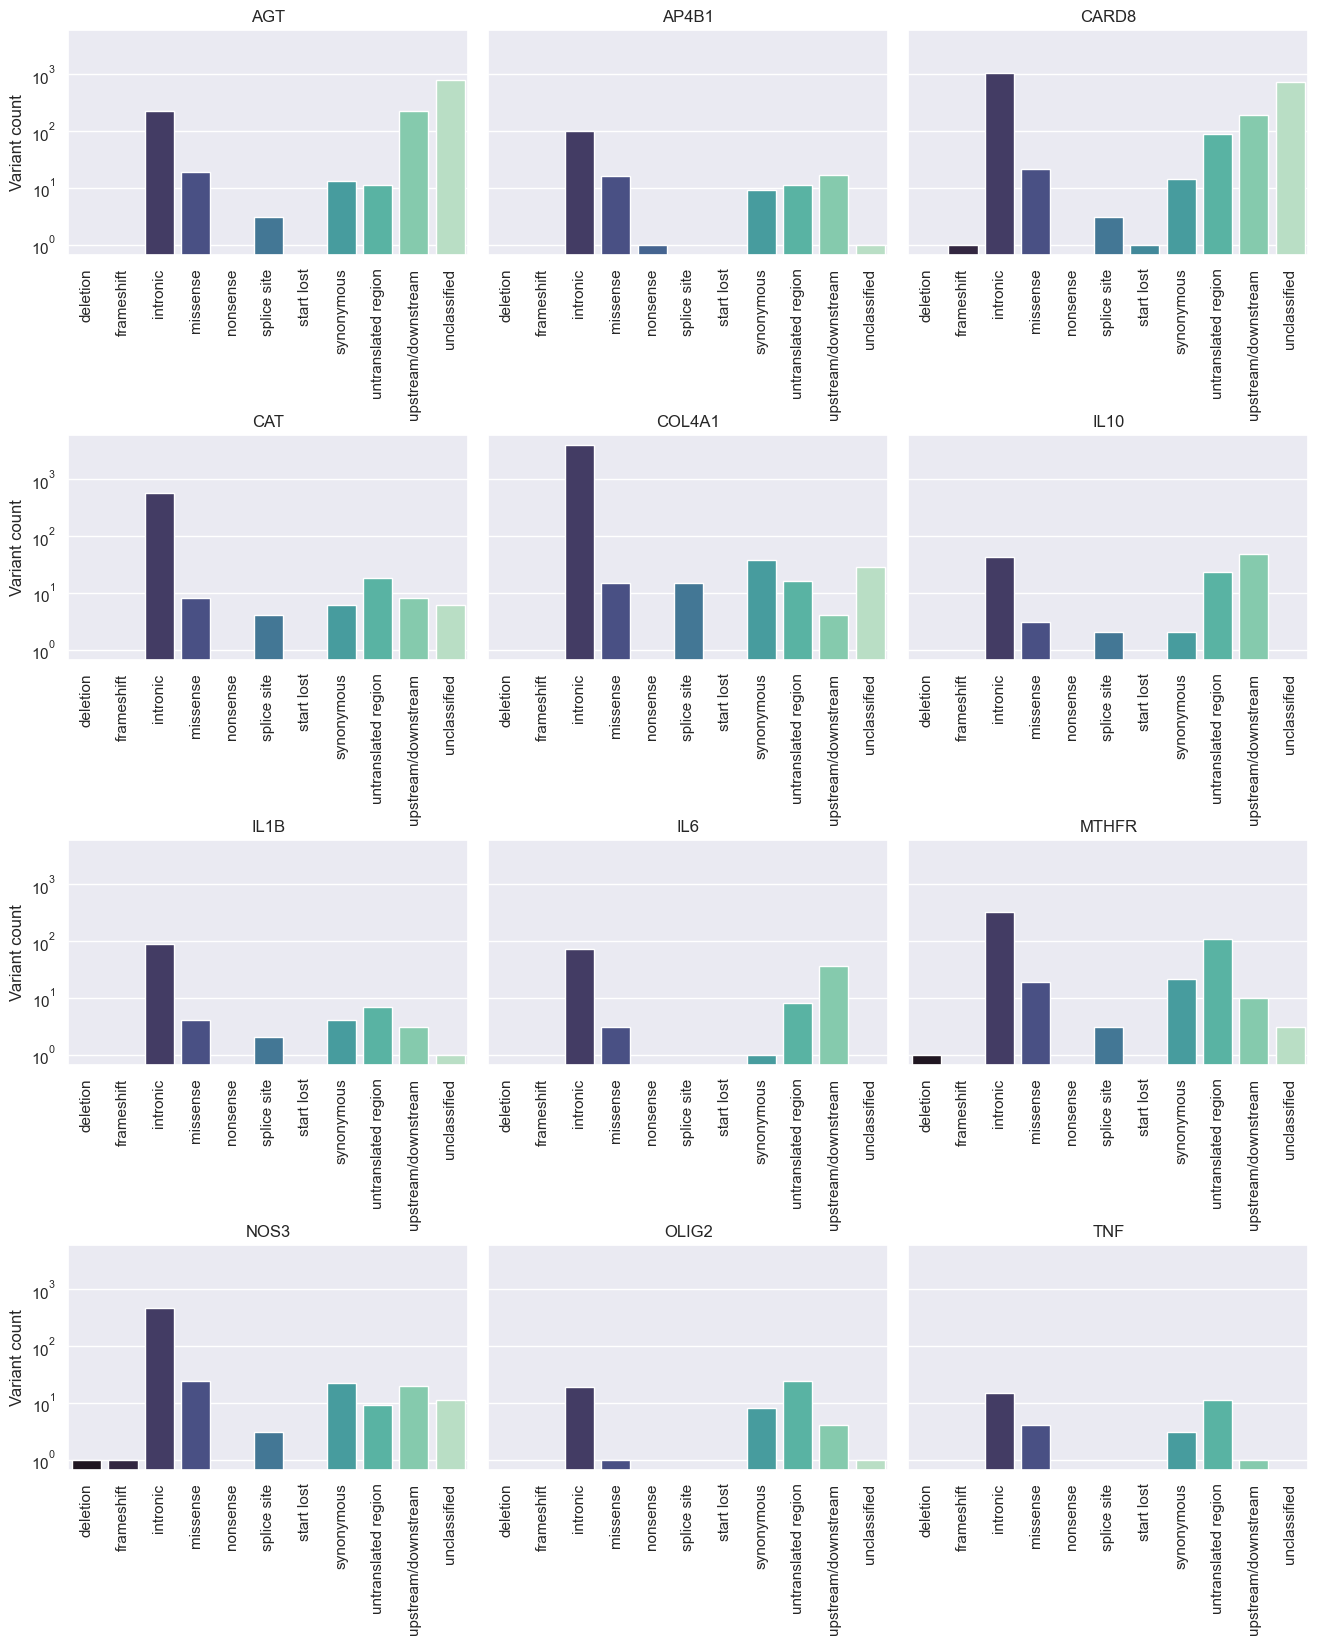

In [96]:
# Define a custom colour palette for plot
custom_palette = sns.color_palette("mako", 11)

# Set seaborn plotting aesthetics as default
sns.set()

# Define plotting region (4 rows, 3 columns)
consequence_plot, axes = plt.subplots(4, 3, sharey=True)
plt. subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=0.9, wspace=0.05, hspace=0.8)

# Create barplot in each subplot
sns.barplot(data=recent_african_consequence_transpose, x='Consequences', y='AGT', ax=axes[0,0], palette=custom_palette)
axes[0][0].tick_params(axis='x', rotation=90)
axes[0][0].set_yscale('log')
axes[0][0].set_title('AGT')
axes[0][0].set_xlabel(None)
axes[0][0].set_ylabel("Variant count")

sns.barplot(data=recent_african_consequence_transpose, x='Consequences', y='AP4B1', ax=axes[0,1], palette=custom_palette)
axes[0][1].tick_params(axis='x', rotation=90)
axes[0][1].set_yscale('log')
axes[0][1].set_title('AP4B1')
axes[0][1].set_xlabel(None)
axes[0][1].set_ylabel(None)

sns.barplot(data=recent_african_consequence_transpose, x='Consequences', y='CARD8', ax=axes[0,2], palette=custom_palette)
axes[0][2].tick_params(axis='x', rotation=90)
axes[0][2].set_yscale('log')
axes[0][2].set_title('CARD8')
axes[0][2].set_xlabel(None)
axes[0][2].set_ylabel(None)

sns.barplot(data=recent_african_consequence_transpose, x='Consequences', y='CAT', ax=axes[1,0], palette=custom_palette)
axes[1][0].tick_params(axis='x', rotation=90)
axes[1][0].set_yscale('log')
axes[1][0].set_title('CAT')
axes[1][0].set_xlabel(None)
axes[1][0].set_ylabel("Variant count")

sns.barplot(data=recent_african_consequence_transpose, x='Consequences', y='COL4A1', ax=axes[1,1], palette=custom_palette)
axes[1][1].tick_params(axis='x', rotation=90)
axes[1][1].set_yscale('log')
axes[1][1].set_title('COL4A1')
axes[1][1].set_xlabel(None)
axes[1][1].set_ylabel(None)

sns.barplot(data=recent_african_consequence_transpose, x='Consequences', y='IL10', ax=axes[1,2], palette=custom_palette)
axes[1][2].tick_params(axis='x', rotation=90)
axes[1][2].set_yscale('log')
axes[1][2].set_title('IL10')
axes[1][2].set_xlabel(None)
axes[1][2].set_ylabel(None)

sns.barplot(data=recent_african_consequence_transpose, x='Consequences', y='IL1B', ax=axes[2,0], palette=custom_palette)
axes[2][0].tick_params(axis='x', rotation=90)
axes[2][0].set_yscale('log')
axes[2][0].set_title('IL1B')
axes[2][0].set_xlabel(None)
axes[2][0].set_ylabel("Variant count")

sns.barplot(data=recent_african_consequence_transpose, x='Consequences', y='IL6', ax=axes[2,1], palette=custom_palette)
axes[2][1].tick_params(axis='x', rotation=90)
axes[2][1].set_yscale('log')
axes[2][1].set_title('IL6')
axes[2][1].set_xlabel(None)
axes[2][1].set_ylabel(None)

sns.barplot(data=recent_african_consequence_transpose, x='Consequences', y='MTHFR', ax=axes[2,2], palette=custom_palette)
axes[2][2].tick_params(axis='x', rotation=90)
axes[2][2].set_yscale('log')
axes[2][2].set_title('MTHFR')
axes[2][2].set_xlabel(None)
axes[2][2].set_ylabel(None)

sns.barplot(data=recent_african_consequence_transpose, x='Consequences', y='NOS3', ax=axes[3,0], palette=custom_palette)
axes[3][0].tick_params(axis='x', rotation=90)
axes[3][0].set_yscale('log')
axes[3][0].set_title('NOS3')
axes[3][0].set_xlabel(None)
axes[3][0].set_ylabel("Variant count")

sns.barplot(data=recent_african_consequence_transpose, x='Consequences', y='OLIG2', ax=axes[3,1], palette=custom_palette)
axes[3][1].tick_params(axis='x', rotation=90)
axes[3][1].set_yscale('log')
axes[3][1].set_title('OLIG2')
axes[3][1].set_xlabel(None)
axes[3][1].set_ylabel(None)

sns.barplot(data=recent_african_consequence_transpose, x='Consequences', y='TNF', ax=axes[3,2], palette=custom_palette)
axes[3][2].tick_params(axis='x', rotation=90)
axes[3][2].set_yscale('log')
axes[3][2].set_title('TNF')
axes[3][2].set_xlabel(None)
axes[3][2].set_ylabel(None)

plt.savefig("..\Results\Figures\Variant_consequences.png", dpi=1200)
plt.show()